In [141]:
import pandas as pd
import numpy as np
import regex as re
from collections import Counter
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

In [142]:
df = pd.read_csv('un-general-debates-blueprint.csv')


In [143]:
df.head(20)

,session,year,country,country_name,speaker,position,text
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ..."
5,25,1970,BLR,Belarus,Mr. GURINOVICH,NaN,\n71.\t. We are today mourning the untimely de...
6,25,1970,BOL,"Bolivia, Plurinational State of",Mr. CAMACHO OMISTE,NaN,135.\t I wish to congratulate the President o...
7,25,1970,BRA,Brazil,Mr. GIBSON BARBOZA,NaN,"1.\tMr. President, I should like, first of all..."
8,25,1970,CAN,Canada,Mr. SHARP,NaN,\nThe General Assembly is fortunate indeed to ...
9,25,1970,CMR,Cameroon,Mr. AHIDJO,President,: A year ago I came here as the Acting Preside...


In [144]:
import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
print(stopwords)

{'some', 'after', 'other', 'ma', 'themselves', 'what', "hadn't", 'herself', 'an', 'under', 'same', 'or', 'have', 'any', 't', 'yours', "shan't", 'doing', 'yourselves', 'your', "shouldn't", 'ain', 'isn', 'too', 'this', "should've", 'whom', 'o', "you'd", 'theirs', "needn't", 'is', 'are', 'again', 're', 'him', 'why', 'y', 'being', 'don', 'off', 'do', 'my', 'wasn', 'for', 'himself', 'was', "don't", 'but', 'wouldn', "mightn't", "wasn't", 'by', 'itself', "didn't", "mustn't", "you've", 'when', 'before', 'd', 'will', 'shouldn', 'having', 'nor', 'if', 's', 'them', 'against', 'shan', 'than', 'few', 'his', 'so', 'he', 'in', 'of', 'needn', "wouldn't", 'into', 'down', 'each', 'did', 'hers', 'hadn', 'it', 'just', 'been', 'doesn', 'further', 'out', 'am', 'those', 'her', 'all', 'does', "you're", "you'll", 'aren', 'above', 'there', "it's", "that'll", 'they', "weren't", 'that', 'were', "hasn't", 'both', 'couldn', 'mustn', 'be', 'haven', 'won', 'which', 'these', 'didn', 'and', 'we', 'as', "haven't", 'here

[nltk_data] Downloading package stopwords to /Users/peter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [145]:
def tokenize(text):
    return re.findall(r'[\w-]*[a-z|A-Z][\w-]*', text)

In [146]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]
pipeline = [str.lower, tokenize, remove_stop]

In [147]:
def prepare(text, pipeline):
    tokens = text
    for fun in pipeline:tokens = fun(tokens)
    return tokens
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)


In [148]:
counter = Counter()
df['tokens'].map(counter.update)
freq_df = pd.DataFrame.from_dict(counter, orient='index',columns=['freq'])
freq_df = freq_df.query('freq >= 1')
freq_df.index.name = 'token'
freq_df = freq_df.sort_values('freq', ascending=False)
freq_df.head(10)

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734
peace,72625
development,62632
states,59713
people,59338


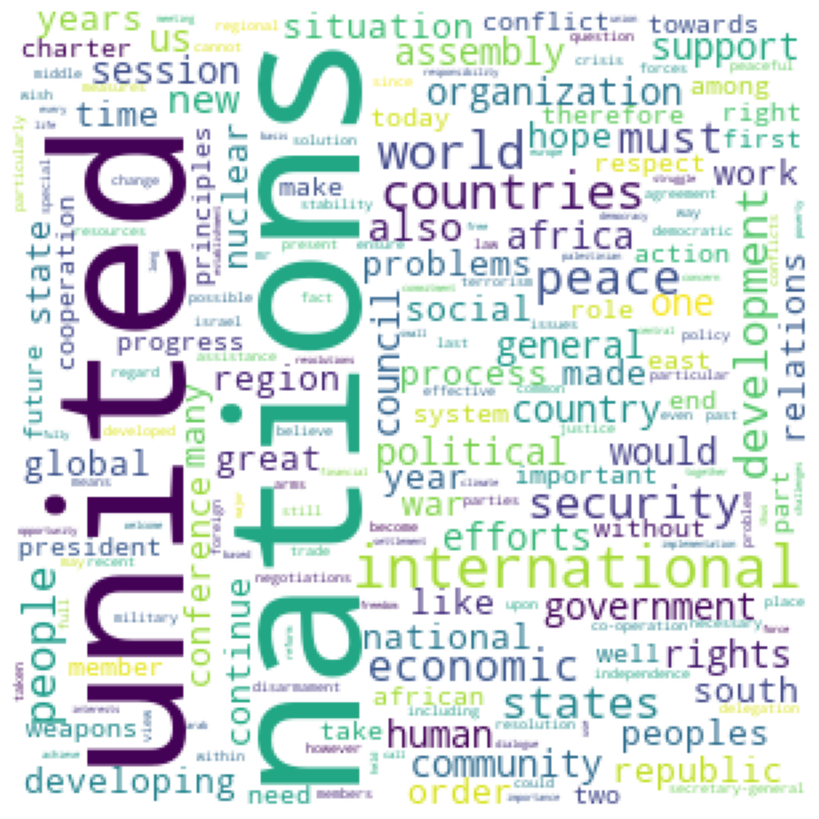

In [150]:
wc = WordCloud(background_color='white', width = 300, height=300, margin=2)
wc.fit_words(freq_df['freq'].to_dict() )
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [151]:
def compute_idf(df, column='tokens', preprocess=None, min_df=1):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))
    counter = Counter()
    df[column].map(update)# create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df
idf_df = compute_idf(df)

In [152]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']
freq_df.head()

,freq,tfidf
token,,
nations,124508,12649.986284
united,120763,12285.608632
international,117223,12364.276226
world,89421,9503.708982
countries,85734,10888.485986


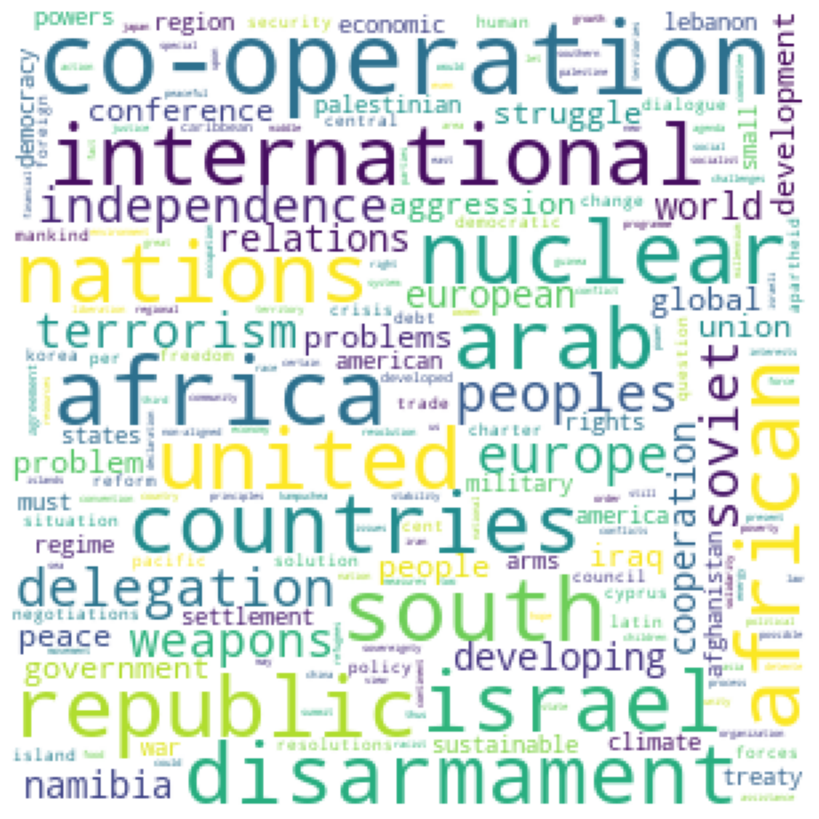

In [153]:
wc = WordCloud(background_color='white', width = 300, height=300,margin=2)
wc.fit_words(freq_df['tfidf'].to_dict() )
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [154]:
df['num_tokens'] = df['tokens'].map(len)
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [155]:
def count_keywords_by(df, by, keywords, column='tokens'):
    df = df.reset_index(drop=True) # if the supplied dataframe has gaps inthe index
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix,columns=keywords)
    freq_df[by] = df[by] # copy the grouping column(s)
    return freq_df.groupby(by=by).sum().sort_values(by)

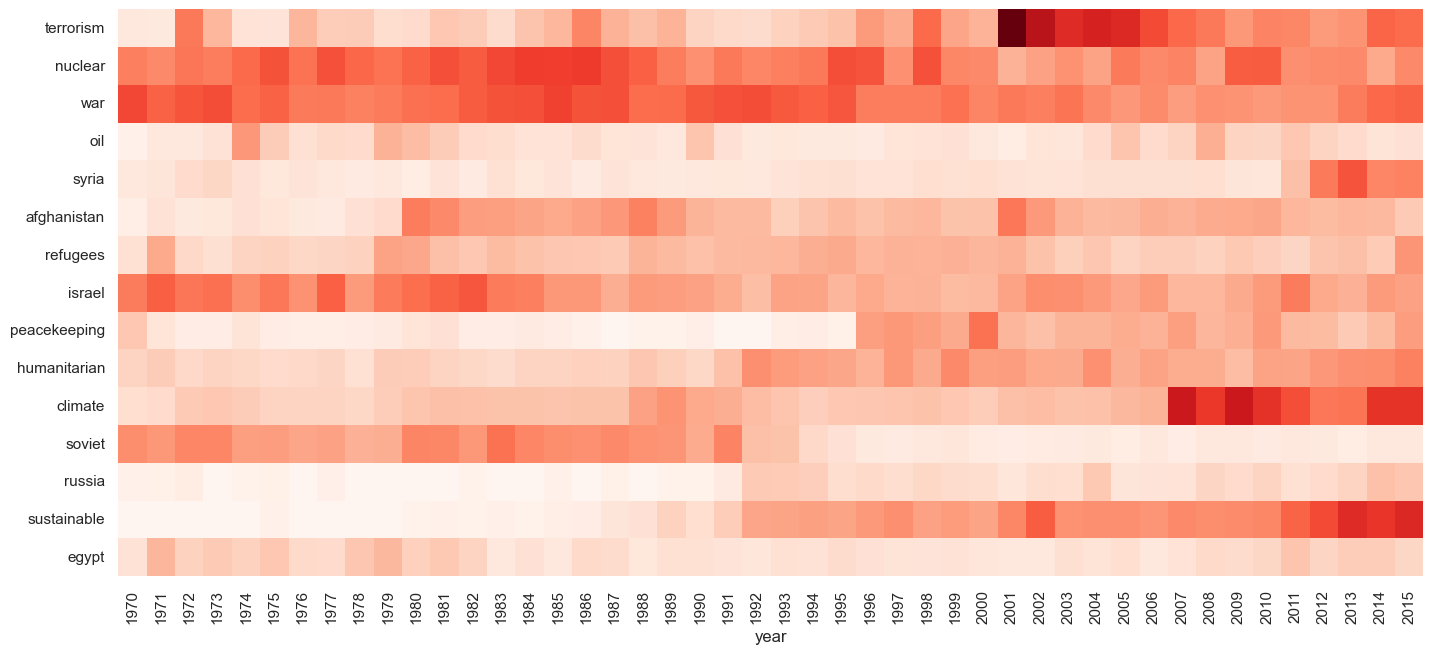

In [156]:
keywords = ['terrorism', 'nuclear', 'war', 'oil','syria', 'afghanistan', 'refugees', 'israel', 'peacekeeping','humanitarian', 'climate', 'soviet','russia', 'sustainable','egypt']
freq_df = count_keywords_by(df, by='year', keywords=keywords)
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)
freq_df = freq_df.apply(np.sqrt)
# Plotting the heatmap
plt.figure(figsize=(15, 7))
sns.set(font_scale=1)
sns.heatmap(data=freq_df.T,xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")
sns.set(font_scale=1)